<a href="https://colab.research.google.com/github/tnguyennr/Intro-to-Sup-Learning-Final/blob/main/Intro_to_Supervised_Learning_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Purpose:

The purpose of this project is to predict a student's grade for a given class given a set of predictors.  Intrepretability is important, because the goals is to improve the students' grades overall by dedicating resources that will help them be successful.  ID'ing students that will struggle, it seems like it'd be better to have false positives so some students would get extra help even if they don't need it as opposed to a student not getting the help they need.











## GitHub Repository URL

[Link to my GitHub repository](https://github.com/tnguyennr/intro_supervised_learning_final)


In [37]:
!git push origin main


fatal: not a git repository (or any of the parent directories): .git


## Load Libraries and Read in Data


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from scipy.stats import chi2_contingency, f_oneway
from sklearn.model_selection import train_test_split

from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
('gdrive/My Drive/data.csv')
student_data = pd.read_csv('/content/gdrive/MyDrive/Student_performance_data _.csv')

In [4]:
student_data.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


# Data Cleaning

In [5]:
#Checking for null
student_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          2392 non-null   int64  
 1   Age                2392 non-null   int64  
 2   Gender             2392 non-null   int64  
 3   Ethnicity          2392 non-null   int64  
 4   ParentalEducation  2392 non-null   int64  
 5   StudyTimeWeekly    2392 non-null   float64
 6   Absences           2392 non-null   int64  
 7   Tutoring           2392 non-null   int64  
 8   ParentalSupport    2392 non-null   int64  
 9   Extracurricular    2392 non-null   int64  
 10  Sports             2392 non-null   int64  
 11  Music              2392 non-null   int64  
 12  Volunteering       2392 non-null   int64  
 13  GPA                2392 non-null   float64
 14  GradeClass         2392 non-null   float64
dtypes: float64(3), int64(12)
memory usage: 280.4 KB


In [6]:
student_data.isna().sum()

StudentID            0
Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
GradeClass           0
dtype: int64

In [7]:
#Create pass/fail column so we can do binary classification
student_data['Pass'] = student_data['GradeClass'].apply(lambda x:1 if x < 3 else 0)

In [8]:
#Even though the data is inputted as int64 and float64, some of the variables should be categorical according to variable dictionary
categorical_variables = ['Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering', 'Pass']
nominal_cat = ['Gender', 'Ethnicity', 'Tutoring', 'Extracurricular', 'Sports', 'Music', 'Volunteering']
ordered_cat = ['Age', 'ParentalEducation', 'ParentalSupport', 'GradeClass']
numerical_variables = ['StudyTimeWeekly', 'Absences', 'GPA']

student_data[categorical_variables] = student_data[categorical_variables].astype('category')

In [9]:
student_data.dtypes

StudentID               int64
Age                  category
Gender               category
Ethnicity            category
ParentalEducation    category
StudyTimeWeekly       float64
Absences                int64
Tutoring             category
ParentalSupport      category
Extracurricular      category
Sports               category
Music                category
Volunteering         category
GPA                   float64
GradeClass            float64
Pass                 category
dtype: object

In [10]:
#Checking descriptive statistics
student_data[numerical_variables].describe()

,StudyTimeWeekly,Absences,GPA
count,2392.000000,2392.000000,2392.000000
mean,9.771992,14.541388,1.906186
std,5.652774,8.467417,0.915156
min,0.001057,0.000000,0.000000
25%,5.043079,7.000000,1.174803
50%,9.705363,15.000000,1.893393
75%,14.408410,22.000000,2.622216
max,19.978094,29.000000,4.000000


In [11]:
#
cat_student_data = student_data[categorical_variables]
value_counts_dict = {col: cat_student_data[col].value_counts().to_dict() for col in cat_student_data.columns}
value_counts_dict

{'Age': {15: 630, 16: 593, 17: 587, 18: 582},
 'Gender': {1: 1222, 0: 1170},
 'Ethnicity': {0: 1207, 1: 493, 2: 470, 3: 222},
 'ParentalEducation': {2: 934, 1: 728, 3: 367, 0: 243, 4: 120},
 'Tutoring': {0: 1671, 1: 721},
 'ParentalSupport': {2: 740, 3: 697, 1: 489, 4: 254, 0: 212},
 'Extracurricular': {0: 1475, 1: 917},
 'Sports': {0: 1666, 1: 726},
 'Music': {0: 1921, 1: 471},
 'Volunteering': {0: 2016, 1: 376},
 'Pass': {0: 1625, 1: 767}}

# Exploratory Data Analysis

## Visualizations

In [12]:
num_rows = (len(categorical_variables) + 2) // 3

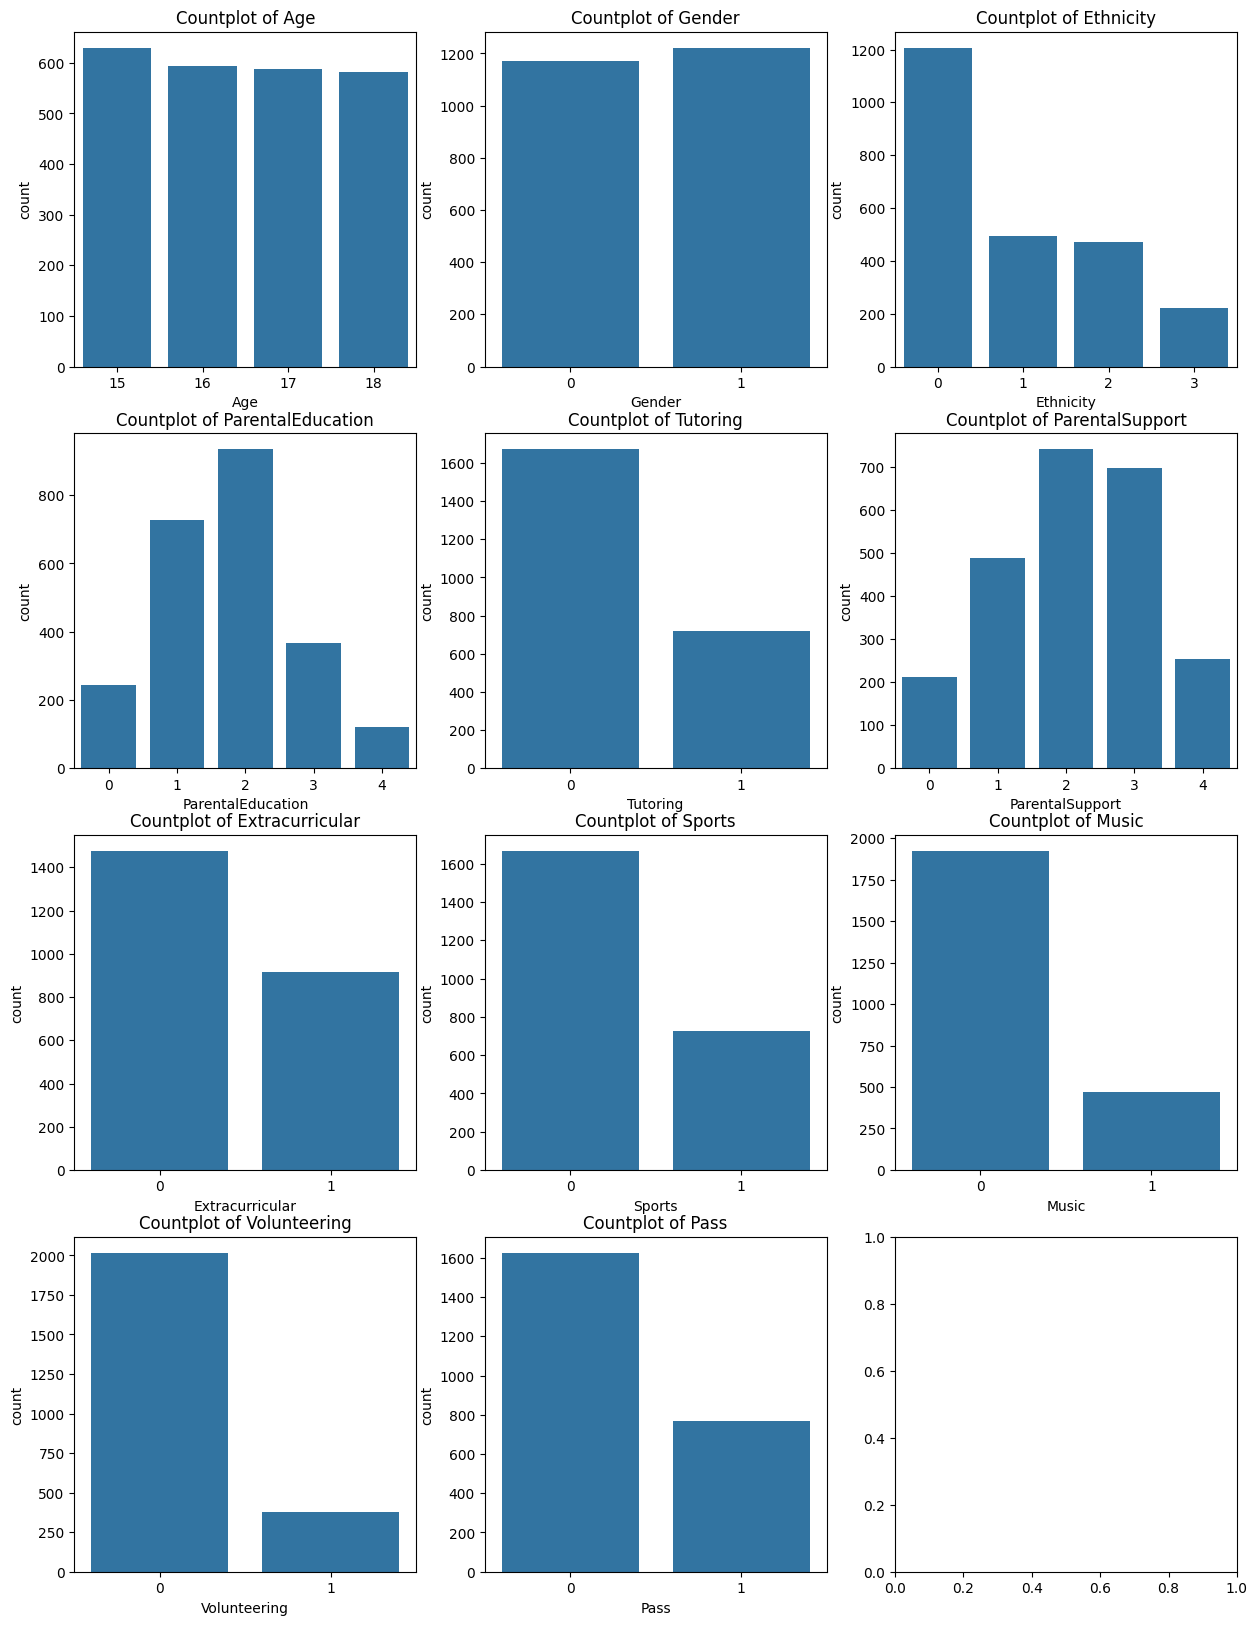

In [13]:
#Plotting all the categorical variables
num_rows = (len(categorical_variables) + 2) // 3

fig, axes = plt.subplots(nrows=num_rows, ncols = 3, figsize = (15,num_rows * 5))

axes = axes.flatten()

for i, col in enumerate(categorical_variables):
  sns.countplot(x = col, data = cat_student_data, ax = axes[i])
  axes[i].set_title(f'Countplot of {col}')

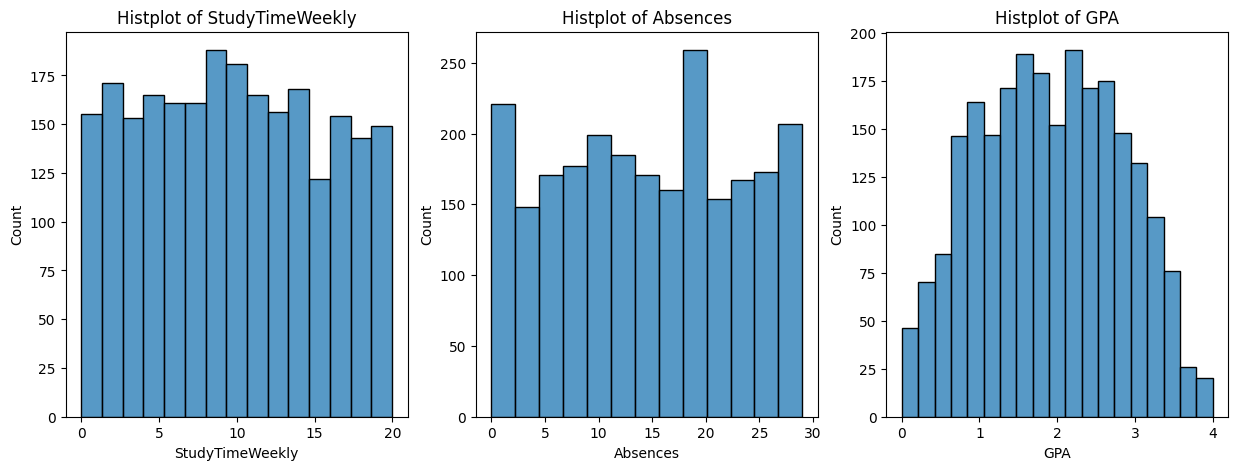

In [14]:

fig, axes = plt.subplots(nrows=1, ncols = 3, figsize = (15, 5))

axes = axes.flatten()

for i, col in enumerate(numerical_variables):
  sns.histplot(x = col, data = student_data, ax = axes[i])
  axes[i].set_title(f'Histplot of {col}')

<Axes: xlabel='Absences', ylabel='GPA'>

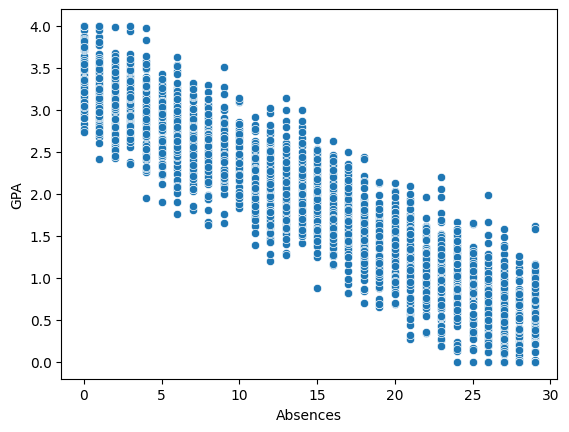

In [15]:
sns.scatterplot(x = student_data['Absences'], y = student_data['GPA'])

Observations:

From histplot of numerical data, gpa looks to be normally distributed but absences and study time weekly look more uniform.  Would this mean they aren't good discriminators to classify for class grade?  Not necessarily because there could be some sort of interactions between for example absences and level of parental support where even if someone has high absences they are more likely to do worse if they have low parental support vs. they could still be likely to do well if they have high parental support (or tutoring)


From countplot of categorical data, most people got Fs and very few got As
Gender and age look balanced, but everything else looks imbalanced.  Seems like we'll have to do the ordinal variables.  Since it is only relevant if they pass or fail, this can be converted to a binary variable with D,F being fail and A,B,C being passed.  

<Axes: xlabel='ParentalEducation', ylabel='Pass'>

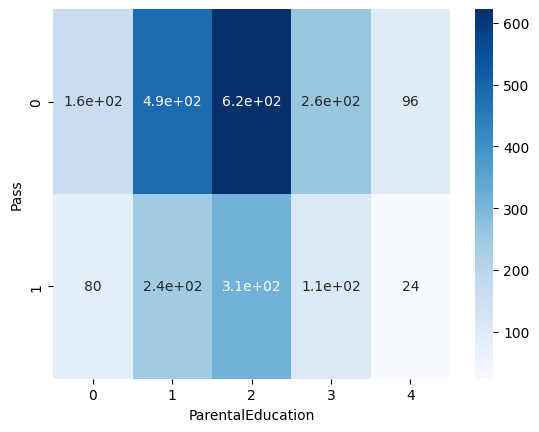

In [16]:
ct = pd.crosstab(student_data['Pass'], student_data['ParentalEducation'])
sns.heatmap(ct, annot = True, cmap = 'Blues')

<Axes: xlabel='Pass', ylabel='count'>

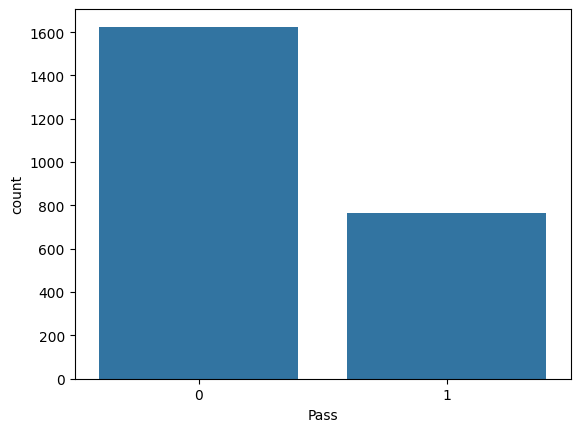

In [17]:
sns.countplot(x = "Pass", data = student_data)

## Statistical Analysis

In [18]:
results = list()



for var in categorical_variables:
  contingency_table = pd.crosstab(student_data[var], student_data['Pass'])
  chi2, p, dof, expected = chi2_contingency(contingency_table)
  results.append({
      'Variable': var,
      "Chi2_stat": chi2,
      "DoF": dof,
      "p_value": p
  })



results_df = pd.DataFrame(results)

In [19]:
results_df[results_df['p_value'] < 0.05]

,Variable,Chi2_stat,DoF,p_value
3,ParentalEducation,10.275152,4,0.036039
4,Tutoring,20.399757,1,0.000006
5,ParentalSupport,23.680109,4,0.000093
6,Extracurricular,10.209367,1,0.001397
10,Pass,2387.411558,1,0.000000


In [20]:
cat_vars = results_df[results_df['p_value'] < 0.05]['Variable'].tolist()
cat_vars.remove('Pass')
cat_vars

['ParentalEducation', 'Tutoring', 'ParentalSupport', 'Extracurricular']

In [21]:
#This is the correct way to group and then pass through anova
groups = student_data.groupby('Pass')['GPA']
results = f_oneway(*[group for name, group in groups])


groups = student_data.groupby('Pass')['GPA']
results = f_oneway(*[group for name, group in groups])
f_statistic, p_value = f_oneway(student_data['GPA'], student_data['Pass'])

results

F_onewayResult(statistic=2326.0442668028563, pvalue=0.0)

In [22]:
anova_results = list()

for var in numerical_variables:
  groups = student_data.groupby('Pass')[var]
  results = f_oneway(*[group for name, group in groups])

  anova_results.append({
      'variable': var,
      'F_stat': results.statistic,
      'p_value': results.pvalue
  })

anova_df = pd.DataFrame(anova_results)

In [23]:
anova_df[anova_df['p_value'] < 0.05]

,variable,F_stat,p_value
0,StudyTimeWeekly,31.255954,2.518747e-08
1,Absences,1883.282145,6.543442e-304
2,GPA,2326.044267,0.000000e+00


In [24]:
num_vars = anova_df[anova_df['p_value'] < 0.05]['variable'].tolist()
num_vars

['StudyTimeWeekly', 'Absences', 'GPA']

In [25]:
predictor_vars = cat_vars + num_vars

Different Classification Models

# Splitting Data

In [26]:
test_data = student_data.copy()

In [27]:
X = test_data[predictor_vars]
Y = test_data['Pass'].astype('category')
X[cat_vars] = X[cat_vars].astype('category')



x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True)

<ipython-input-27-f9bf3c6e6232>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_vars] = X[cat_vars].astype('category')


In [28]:
# Define which columns are categorical and numerical


# Preprocessing pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars)
    ])


In [29]:
column_indicies = {col: idx for idx, col in enumerate(X.columns)}

categorical_columns = cat_vars

categorical_indices = [column_indicies[col] for col in categorical_columns]



# Logistic Regression Model

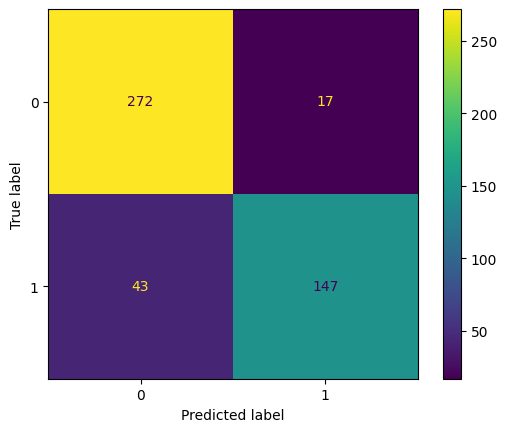

In [30]:
new_lr = LogisticRegression(class_weight = 'balanced', random_state = 81)
new_lr.fit(x_train, y_train)

new_lr_pred = new_lr.predict(x_test)

new_lr_confusion_matrix = confusion_matrix(new_lr_pred, y_test)
ConfusionMatrixDisplay(new_lr_confusion_matrix).plot()

# Random Forest Model

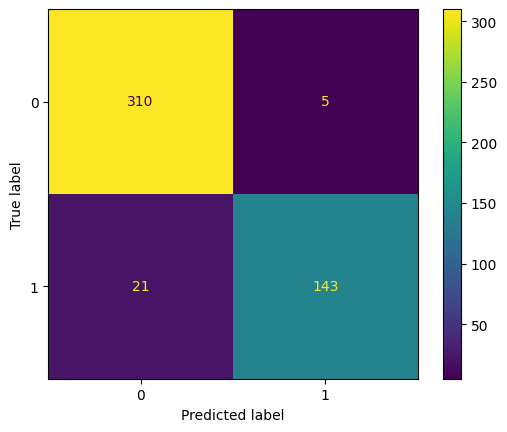

In [31]:
new_rfc = RandomForestClassifier(random_state=41, class_weight = 'balanced')
new_rfc.fit(x_train, y_train)

new_rfc_pred = new_rfc.predict(x_test)

new_rfc_confusion_matrix = confusion_matrix(y_test, new_rfc_pred)
ConfusionMatrixDisplay(new_rfc_confusion_matrix).plot()

# Compare Model Performance and give rec/reasoning

In [32]:
lr_confusion_matrix = confusion_matrix(y_test, new_lr_pred)
rfc_confusion_matrix = confusion_matrix(y_test, new_rfc_pred)


In [33]:
models = [new_lr, new_rfc]
model_names = ['Logistic Regression', "Random Forest"]

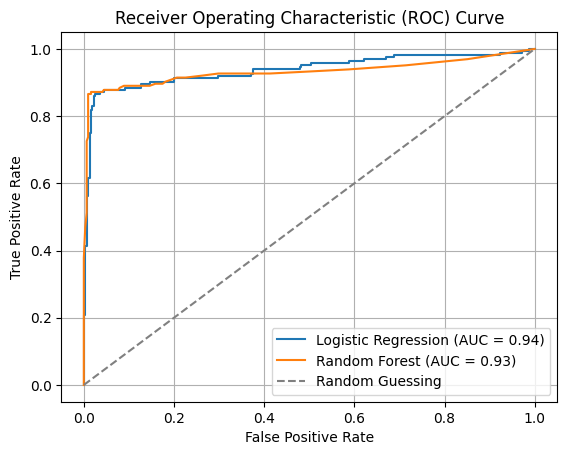

In [34]:
for model, name in zip(models, model_names):
    y_pred_prob = model.predict_proba(x_test)[:, 1]  # Probability predictions for class 1
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [35]:



# Initialize lists to store scores
precision_scores = []
recall_scores = []
f1_scores = []

# Compute precision, recall, and f1 score for each model
for model, name in zip(models, model_names):
    y_pred = model.predict(x_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    #roc_auc = roc_auc_score(y_test, y_pred)

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"{name}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    #print(f"AUC Score: {roc_auc: .2f}")
    print()



Logistic Regression:
Precision: 0.77
Recall: 0.90
F1 Score: 0.83

Random Forest:
Precision: 0.97
Recall: 0.87
F1 Score: 0.92



Text(0, 0.5, 'Mean decrease in impurity')

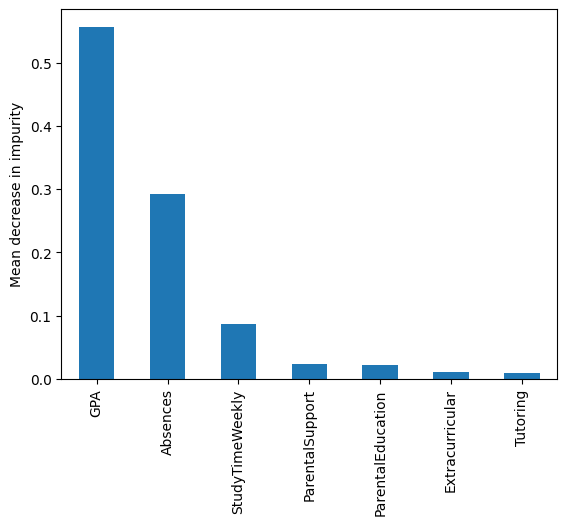

In [36]:
std = np.std([new_rfc.feature_importances_ for tree in new_rfc.estimators_], axis = 0)


importances = new_rfc.feature_importances_
forest_importances = pd.Series(importances, index = predictor_vars)

forest_importances_sorted = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances_sorted.plot.bar(yerr=std, ax = ax)
ax.set_ylabel("Mean decrease in impurity")

# Conclusions

The random forest model seems to be the most suitable model for our given purpose due to the fact that it has a higher precision score.  We want to minimze false negatives, so we select the model that performed best in terms of precision.  


Using mean decrease impurity, it appears that a student's current GPA, number of absences, and amount of weekly study time are the most important features in predicting whether or not a student will pass the class.  Parental support is is also also important and something that can be changed to a greater degree than another feature such as parental education.  


Knowing these are important, we can strategize how to allocate resources or give advice for students to improve their chances of passing the class.  Further research and analysis can be done to examine if there is a way to decrease absences, which could possibly improve the students' odds for passing.  It also appears that there is a relationship between number of absences and gpa where the higher the gpa, the lower the number of absences the higher the gpa.  These are related, but may also be explained by a confounder.  In conclusion, further research should be done in examining the causal effects of these predictor variables on the target variable.